In [2]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_carbon_intensity(start_date, end_date):
    """
    Pulls carbon intensity data between two ISO8601 date strings (YYYY-MM-DDThh:mmZ)
    """
    url = f"https://api.carbonintensity.org.uk/intensity/{start_date}/{end_date}"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")
    data = response.json()['data']
    
    # Parse into DataFrame
    df = pd.DataFrame([{
        'from': item['from'],
        'to': item['to'],
        'forecast': item['intensity']['forecast'],
        'actual': item['intensity']['actual'],
        'index': item['intensity']['index']
    } for item in data])
    
    df['from'] = pd.to_datetime(df['from'])
    df['to'] = pd.to_datetime(df['to'])
    df.set_index('from', inplace=True)
    return df

# Set time range
end = datetime.utcnow()
start = end - timedelta(days=7)

start_str = start.strftime('%Y-%m-%dT%H:%MZ')
end_str = end.strftime('%Y-%m-%dT%H:%MZ')

# Pull the data
carbon_df = get_carbon_intensity(start_str, end_str)

# Save to CSV
carbon_df.to_csv("carbon_intensity_last_7_days.csv")
print("Saved carbon intensity data to carbon_intensity_last_7_days.csv")

Saved carbon intensity data to carbon_intensity_last_7_days.csv


In [3]:
#print out columns
print(carbon_df.columns)

Index(['to', 'forecast', 'actual', 'index'], dtype='object')


                       from                         to  forecast  actual  \
0 2025-06-15 17:30:00+00:00  2025-06-15 18:00:00+00:00       108     131   
1 2025-06-15 18:00:00+00:00  2025-06-15 18:30:00+00:00       126     134   
2 2025-06-15 18:30:00+00:00  2025-06-15 19:00:00+00:00       135     138   
3 2025-06-15 19:00:00+00:00  2025-06-15 19:30:00+00:00       139     141   
4 2025-06-15 19:30:00+00:00  2025-06-15 20:00:00+00:00       140     139   

      index  
0  moderate  
1  moderate  
2  moderate  
3  moderate  
4  moderate  
from        datetime64[ns, UTC]
to                       object
forecast                  int64
actual                    int64
index                    object
dtype: object


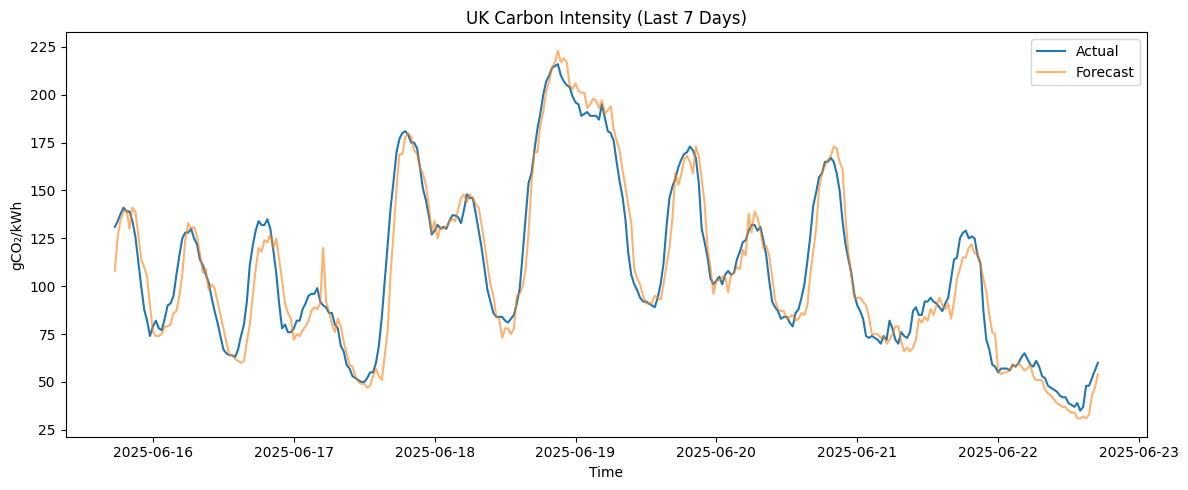

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("carbon_intensity_last_7_days.csv", parse_dates=['from'])

# Check structure
print(df.head())
print(df.dtypes)

# Plot actual vs forecasted carbon intensity
plt.figure(figsize=(12, 5))
plt.plot(df['from'], df['actual'], label='Actual')
plt.plot(df['from'], df['forecast'], label='Forecast', alpha=0.6)
plt.title("UK Carbon Intensity (Last 7 Days)")
plt.ylabel("gCO₂/kWh")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import requests
import pandas as pd
from datetime import datetime

API_KEY = '9b059358d2b7b09b3538037f534ca1b8'
CITY = 'London'
URL = f'http://api.openweathermap.org/data/2.5/forecast?q={CITY}&appid={API_KEY}&units=metric'

def get_weather_forecast():
    response = requests.get(URL)
    if response.status_code != 200:
        raise Exception(f"Failed: {response.status_code}, {response.text}")
    data = response.json()
    forecast_list = data['list']

    # Parse forecast data
    forecast_data = []
    for entry in forecast_list:
        forecast_data.append({
            'timestamp': datetime.utcfromtimestamp(entry['dt']),
            'temp': entry['main']['temp'],
            'wind_speed': entry['wind']['speed'],
            'clouds': entry['clouds']['all'],
        })

    df = pd.DataFrame(forecast_data)
    df.set_index('timestamp', inplace=True)
    return df

# === RUN ===
weather_df = get_weather_forecast()
weather_df.to_csv("forecast_weather_london.csv")
print("Saved 5-day weather forecast to forecast_weather_london.csv")

Saved 5-day weather forecast to forecast_weather_london.csv


In [6]:
import requests
import pandas as pd
from datetime import datetime, timedelta

def get_forecast_carbon_intensity():
    # Get forecast for the next 5 days
    start = datetime.utcnow()
    end = start + timedelta(days=5)

    start_str = start.strftime('%Y-%m-%dT%H:%MZ')
    end_str = end.strftime('%Y-%m-%dT%H:%MZ')

    url = f"https://api.carbonintensity.org.uk/intensity/{start_str}/{end_str}"
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed: {response.status_code}, {response.text}")

    data = response.json()['data']

    # Create DataFrame
    df = pd.DataFrame([{
        'timestamp': pd.to_datetime(item['from']),
        'forecast': item['intensity']['forecast'],
        'index': item['intensity']['index']
    } for item in data])

    df.set_index('timestamp', inplace=True)

    # Resample only numeric column (forecast), not 'index' (which is text)
    forecast_only = df[['forecast']].resample("3H").mean()
    index_only = df[['index']].resample("3H").first()  # Use first string entry in each 3H window

    # Combine both into final dataframe
    resampled_df = pd.concat([forecast_only, index_only], axis=1).dropna()

    return resampled_df

# Run the function and save output
carbon_df = get_forecast_carbon_intensity()
carbon_df.to_csv("forecast_carbon_intensity.csv")
print("Saved 5-day forecast carbon intensity to forecast_carbon_intensity.csv")

Saved 5-day forecast carbon intensity to forecast_carbon_intensity.csv


/var/folders/qw/79nxyn5d47j02_6z_dxrc0p80000gn/T/ipykernel_15506/921482301.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_only = df[['forecast']].resample("3H").mean()
/var/folders/qw/79nxyn5d47j02_6z_dxrc0p80000gn/T/ipykernel_15506/921482301.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_only = df[['index']].resample("3H").first()  # Use first string entry in each 3H window


In [7]:
pip install --upgrade scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd

# Load weather (naive datetime)
weather_df = pd.read_csv("forecast_weather_london.csv", parse_dates=['timestamp'])

# Load carbon (likely timezone-aware)
carbon_df = pd.read_csv("forecast_carbon_intensity.csv", parse_dates=['timestamp'])

# Strip timezone info from carbon timestamps (convert to naive datetime)
carbon_df['timestamp'] = carbon_df['timestamp'].dt.tz_localize(None)

# Now both are naive (no timezone)
merged_df = pd.merge(weather_df, carbon_df, on='timestamp', how='inner')

# Drop any missing values
merged_df.dropna(inplace=True)

# Save to CSV
merged_df.to_csv("forecast_weather_carbon_merged.csv", index=False)
print(" Merged forecast dataset saved to forecast_weather_carbon_merged.csv")

 Merged forecast dataset saved to forecast_weather_carbon_merged.csv


MAE: 29.02 gCO₂/kWh
RMSE: 30.77 gCO₂/kWh


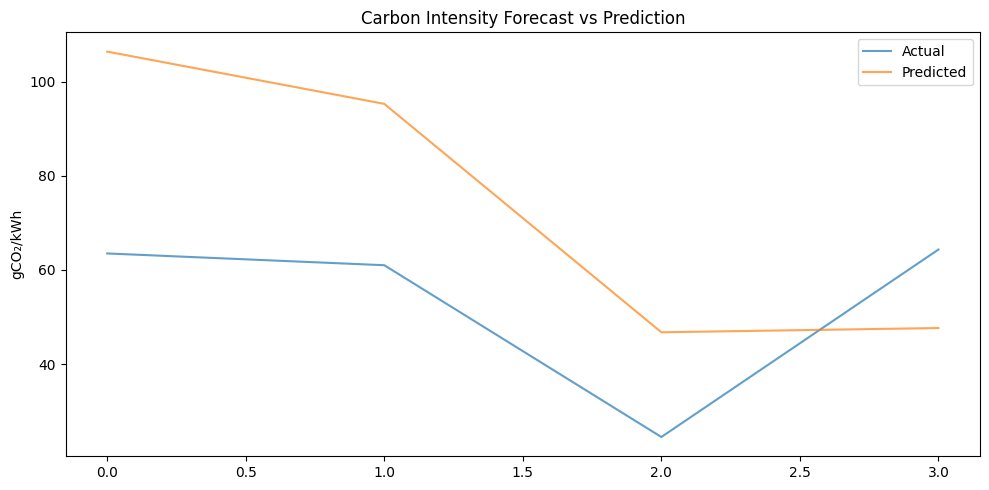

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Load merged data
df = pd.read_csv("forecast_weather_carbon_merged.csv", parse_dates=['timestamp'])

# Feature engineering
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Input features and target
features = ['temp', 'wind_speed', 'clouds', 'hour', 'dayofweek']
X = df[features]
y = df['forecast']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f} gCO₂/kWh")
print(f"RMSE: {rmse:.2f} gCO₂/kWh")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.title("Carbon Intensity Forecast vs Prediction")
plt.ylabel("gCO₂/kWh")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(mae, "gCO₂/kWh")
print(rmse, "gCO₂/kWh")

29.024936868447956 gCO₂/kWh
30.772720327285757 gCO₂/kWh
